#### aim: use EMG channel power to detect state-switches

In [1]:
import os
import pdb

import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt

from scipy import signal


#import plottools as pt
import remtools as rt
#import scoreblock as sb
#import eegplotter as ep

%matplotlib inline
%load_ext autoreload

In [27]:
# 335, 336, 345, 347, 374
edfFile = '../data/raw_edf/400hz/374.edf'

In [28]:
edf = rt.EDFData(edf=edfFile)

-----------------------------------------------------------------------
file               : ../data/raw_edf/400hz/374.edf
trial              : 374
num datarecords    : 8640
num annotations    : 0
number of signals  : 4
duration [s]       : 86400
startdatetime      : 2019-01-02 9:00:00
epoch duration [s] : 10.0
samples in file    : [34560000 34560000 34560000  3456000]
samples_per_epoch  : [4000. 4000. 4000.  400.]
frequency [Hz]     : [400. 400. 400.  40.]
signal_labels      : ['EEG1', 'EEG2', 'EMG', 'EDFAnnotations']
------------------------------------
  loading signal trace: EEG1
  loading signal trace: EEG2
  loading signal trace: EMG
  loading signal trace: EDFAnnotations
  computing spectrogram: EEG1
  computing spectrogram: EEG2
  computing spectrogram: EMG
  edf load complete: ../data/raw_edf/400hz/374.edf
-----------------------------------------------------------------------


In [29]:
%autoreload 2

# EMG signal trace
edf.signal_traces['EMG'].about()
st = edf.signal_traces['EMG']

---- SignalTrace.about() ----
label : EMG
sig : [ 0.0986139   4.03717006  1.13248489 ...  8.17265402  0.68939733
 15.65591071]
f : 400.0
samples_per_epoch : 4000.0
num_samples : 34560000
duration : 86400.0
epoch_duration : 10.0
num_epochs : 8640.0
-----------------


In [30]:
def anlEMGPowerTimeSeries(t=None, p=None, bins=50):
    """
    
    input
    ------
    t (array) : time values [s]
    p (array) : power values
    bin_edges (array) : for histogramming p
    """
    
    logpow = p
    tval = t
    gmmkwa = dict(n_components=2)

    # EMG power histogram
    hy, _ = np.histogram(logpow, bins=bins)
    hy = hy/len(logpow)

    # make a Gaussian Mixture Model
    clf = mixture.GaussianMixture(**gmmkwa).fit(logpow.reshape(-1,1))
    
    # modified GMM classifier with a crossover (xx) region
    gmm2 = TwoStateGMMClassifier(clf=clf)
    
    dd = dict(
        t=t,
        p=p,
        hy=hy,
        gmm=clf,
        gmm2=gmm2,
    )
    
    return dd
    
    
class TwoStateGMMClassifier(object):
    """slightly modified gaussian mixture model
    
    
    
    Uses the input classifier (sklearn.mixture.GMM) with two exceptions:
    
    1) To correct for spurious assignments at the data limits:
        if x < mu_0, then assign state0
        if x > mu_1, then assign state1
    
    2) Points close to the (inner) decision boundary are assigned the switch state
       if |p0-p1| < pdiff
    
    """
    def __init__(self, clf=None):
        """
        
        input
        ------
        clf : (sklearn.mixture.GMM) Two state, 1D GMM (wlog mu_0 < mu_1)
        
        """
        
        self.clf = clf
        self.means = clf.means_.ravel()
        self.covs = clf.covariances_.ravel()
        self.weights = clf.weights_.ravel()

        self.x0 = np.min(self.means)
        self.x1 = np.max(self.means)


    def xinterval(self, pdiff=0.9):
        """find the switch interval numerically"""

        xx = np.linspace(self.x0, self.x1, 1000)
        pred_probs = self.clf.predict_proba(xx.reshape(-1, 1))
        pred_probs_diff = abs(pred_probs[:,0]-pred_probs[:,1])

        ndx = np.where(pred_probs_diff < pdiff)[0]

        return xx[[ndx[0], ndx[-1]]]


    def predict(self, X, pdiff=0.9):
        """predict state

        input
        ------
        X : input data
        pdiff : classify as switch if |p0(x)-p1(x)| < pdiff

        output
        ------
        pred : np.array of predictions in {0,1,-1} (-1 for switching)
        """

        pred_probs = self.clf.predict_proba(X.reshape(-1, 1))
        pred_probs_diff = abs(pred_probs[:,0]-pred_probs[:,1])

        # find low/mid/high regions
        is_low = X < np.min(self.means)
        is_hgh = X > np.max(self.means)
        is_mid = ~is_low & ~is_hgh

        # find switch interval
        is_switch = is_mid & (pred_probs_diff < pdiff)

        # start with clf predictions, then correct low/high/switch regions
        pred = self.clf.predict(X.reshape(-1, 1))
        pred[is_low] = 0
        pred[is_hgh] = 1
        pred[is_switch] = -1

        return pred

In [31]:
# spectrogram massage

from sklearn import mixture

pEMG = dict(lowpass=120, highpass=100, logscale=False, normalize=False, medianfilter=None, stride=1)


gmmkwa = dict(n_components=2)

epoch_lengths = [1, 2, 5, 10]

bin_edges = np.linspace(-7, 7, 60)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

data = []
for el in epoch_lengths:
    #print(st.f, el, st.f*el)

    print('====================')
    print('epoch length [s]:', el)
    print('points/epoch    :', st.f*el)
    
    
    # compute EMG spectrograms (w cleanup)
    wsize = int(st.f*el)
    spec = rt.Spectrogram.from_signal(
        sig=st.sig,
        fs=st.f,
        nperseg=wsize,
        noverlap=0,
        label='EMG'
    )

    pp = spec.prep(pEMG)

    # EMG power time series
    logpow = np.log(np.mean(pp.Sxx, axis=0))
    tval = (np.arange(len(logpow)))*el


    mfw = 90
    mfwidth = int(mfw/el/2)*2+1

    print('median filter w :', mfwidth)
    
    lpmf90 = signal.medfilt(logpow, kernel_size=[mfwidth])

    
    tser = {}
    tser['raw'] = anlEMGPowerTimeSeries(t=tval, p=logpow, bins=bin_edges)
    tser['mf90'] = anlEMGPowerTimeSeries(t=tval, p=lpmf90, bins=bin_edges)

    
#     for k,v in tser.items():
#         print('=========================')
#         print(k)
#         for kk in v.keys():
#             print('  ', kk)



    # EMG power histogram
    hy, _ = np.histogram(logpow, bins=bin_edges)
    hy = hy/len(tval)

    # make a Gaussian Mixture Model
    clf = mixture.GaussianMixture(**gmmkwa).fit(logpow.reshape(-1,1))
    gmm = dict(
        clf=clf,
        weights=clf.weights_.ravel(),
        means=clf.means_.ravel(),
        covs=clf.covariances_.ravel()
    )

    
    
    # TODO: time domain
    # - bandpass filter signals
    # - rms power
    # see:
    #   https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
    #   https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
    #
    
    
    # DATA TO BUNDLE
    # histogram, tval, logpow
    dd = dict(
        epochLength=el,
        pointsPerEpoch=wsize,
        tser=tser,
        tval=tval,
        logpow=logpow,
        gmm=gmm,
        hy=hy,
    )

    data.append(dd)


epoch length [s]: 1
points/epoch    : 400.0
median filter w : 91
epoch length [s]: 2
points/epoch    : 800.0
median filter w : 45
epoch length [s]: 5
points/epoch    : 2000.0
median filter w : 19
epoch length [s]: 10
points/epoch    : 4000.0
median filter w : 9


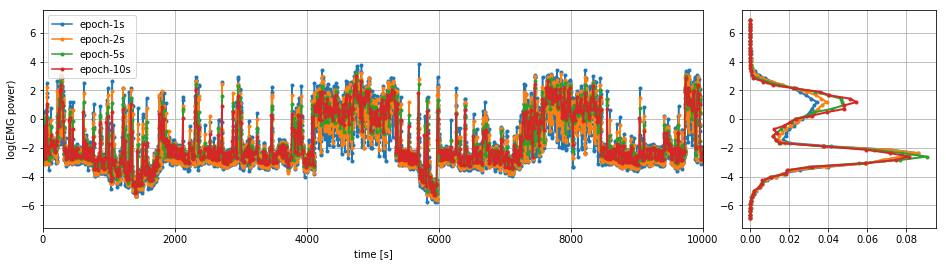

In [32]:
# PLOTTING EMG power time-series and distribution
figx = plt.figure(figsize=(16, 4))
ax = [plt.subplot(1, 4, (1, 3))]
ax.append(plt.subplot(1, 4, 4, sharey=ax[0]))

for dd in data:
    el = dd['epochLength']
    raw = dd['tser']['raw']
    
    ax[0].plot(raw['t'], raw['p'], '-o', ms=3, label='epoch-%is' % (el))
    ax[1].plot(raw['hy'], bin_centers, '-o', lw=2, ms=3)

# fancy stuff
ax[0].set_xlim([0, 10000])
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel('log(EMG power)')
ax[0].set_xlabel('time [s]')

ax[1].grid()

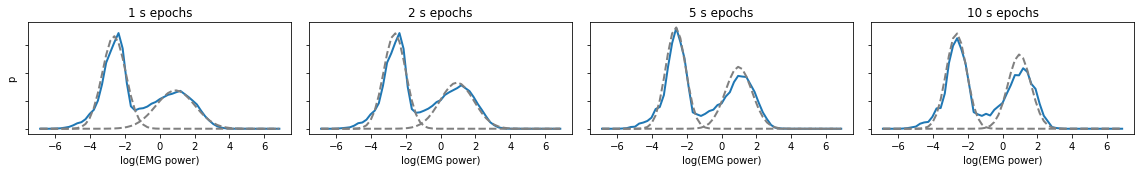

In [33]:
# plot GMMS for raw time series

import scipy.stats

numcols = len(data)
fig = plt.figure(figsize=(4*numcols, 2.5))

ax = [plt.subplot(1, numcols, 1)]
ax += [plt.subplot(1, numcols, i+1, sharey=ax[0]) for i in range(1,numcols)]

for i, dd in enumerate(data):
    
    hh = dd['tser']['raw']['hy']
    gmm2 = dd['tser']['raw']['gmm2']
    xx = bin_centers
    wmc = zip(gmm2.weights, gmm2.means, gmm2.covs)
    
    ax[i].plot(bin_centers, hh, lw=2)

    for ww, mm, cc in wmc:
        yy = scipy.stats.norm.pdf(bin_centers, mm, cc)
        yy = yy/np.sum(yy.ravel())
        ax[i].plot(bin_centers, yy*ww, '--', lw=2, color='grey')


    # fancy stuff
    ax[i].set_title('%i s epochs' % (dd['epochLength']))
    ax[i].set_xlabel('log(EMG power)')
    if i>0:
        ax[i].set_yticklabels([])

ax[0].set_ylabel('p')
    
plt.tight_layout()

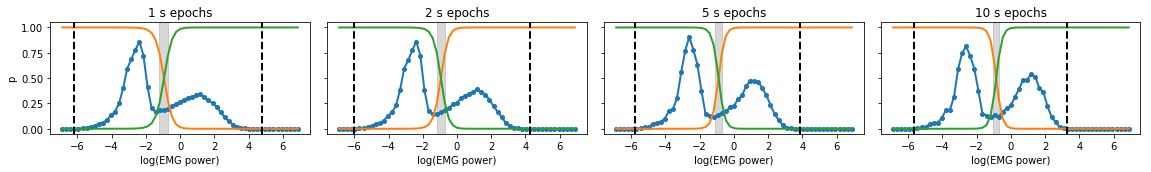

In [34]:
# plot GMM prediction intervals

numcols = len(data)
fig = plt.figure(figsize=(numcols*4, 2.5))
ax = [plt.subplot(1, numcols, i+1) for i in range(numcols)]

yfudge = 10
pdiff = 0.5

for i, dd in enumerate(data):
    hh = dd['tser']['raw']['hy']
    xx = bin_centers
    gmm = dd['tser']['raw']['gmm']
    gmm2 = dd['tser']['raw']['gmm2']    
    pmin = np.min(dd['tser']['raw']['p'])
    pmax = np.max(dd['tser']['raw']['p'])
    

    # histogram
    ax[i].plot(bin_centers, hh*yfudge, '-o', lw=2, ms=4)

    # crossover (xx) region from modified GMM classifier
    xxlim = gmm2.xinterval(pdiff=pdiff)
    ax[i].axvspan(xmin=xxlim[0], xmax=xxlim[1], color='grey', alpha=0.3)
    
    # predicted state probabilities
    yyy = gmm.predict_proba(xx.reshape(-1, 1))
    ax[i].plot(xx, yyy, lw=2)
    
    # actual data bounds
    ax[i].axvline(pmin, color='k', ls='--', lw=2)
    ax[i].axvline(pmax, color='k', ls='--', lw=2)
    
    # fancy stuff
    ax[i].set_title('%i s epochs' % (dd['epochLength']))
    ax[i].set_xlabel('log(EMG power)')
    ax[i].set_ylabel('p')
    if i>0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel('')
    
plt.tight_layout()

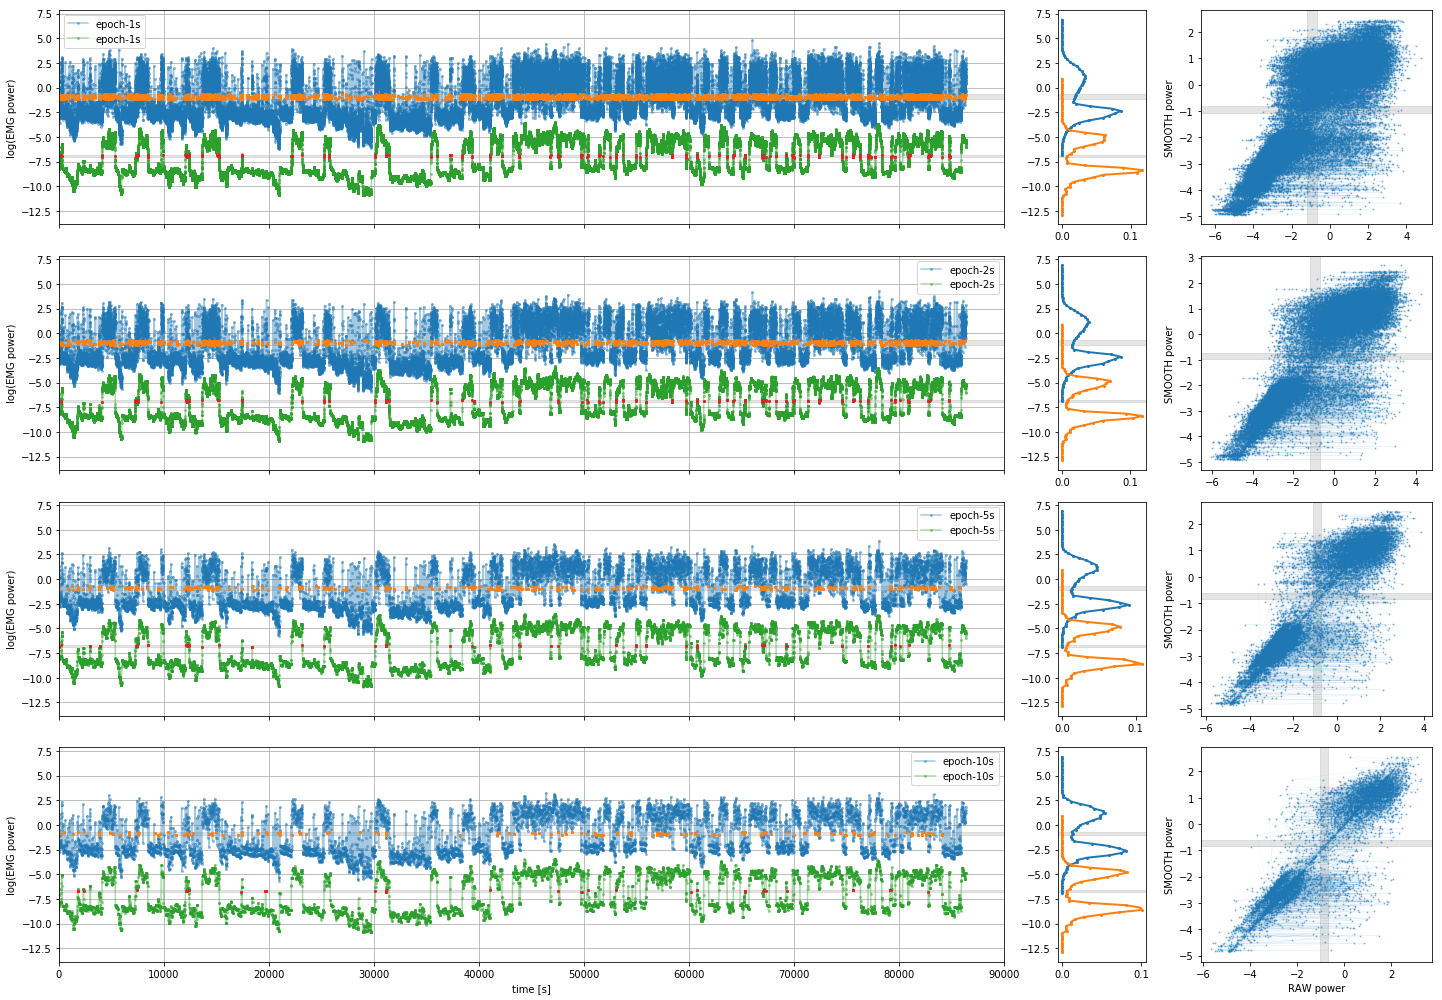

In [35]:

# PLOTTING EMG power time-series and distribution
figxx = plt.figure(figsize=(20, 14))

#axbot = [plt.subplot(2, 4, (5, 7), sharex=ax[0])]

pdiff = 0.5

numrow = len(data)

for row, dd in enumerate(data):
    el = dd['epochLength']
    
    raw = dd['tser']['raw']
    pmf90 = dd['tser']['mf90']

    
    ncol = 10
    ax = [plt.subplot(4, ncol, (ncol*row+1, ncol*row+7))]
    ax.append(plt.subplot(4, ncol, ncol*row+8, sharey=ax[0]))
    ax.append(plt.subplot(4, ncol, (ncol*row+9, ncol*row+10)))
    

    for i, ts in enumerate([raw, pmf90]):
        dy = -6*i

        # time series
        ax[0].plot(ts['t'], ts['p']+dy, '-o', ms=2, alpha=0.4, label='epoch-%is' % (el))

        # GMM predictions of switch intervals
        yy = ts['gmm2'].predict(X=ts['p'], pdiff=pdiff)
        ndx_switch = np.where(yy==-1)[0]
        ax[0].plot(ts['t'][ndx_switch], ts['p'][ndx_switch]+dy, 'o', ms=2, lw=0)

        # band
        ylm = ts['gmm2'].xinterval(pdiff=pdiff)+dy
        ax[0].axhspan(ylm[0], ylm[1], color='grey', alpha=0.2)


        ax[1].plot(ts['hy'], bin_centers+dy, '-o', lw=2, ms=2)
        ax[1].axhspan(ylm[0], ylm[1], color='grey', alpha=0.2)


    
    xlm = raw['gmm2'].xinterval(pdiff=pdiff)
    ylm = pmf90['gmm2'].xinterval(pdiff=pdiff)
    
    ax[2].plot(raw['p'], pmf90['p'], '-o', lw=0.1, ms=1, alpha=0.4)
    ax[2].axvspan(xlm[0], xlm[1], color='grey', alpha=0.2)
    ax[2].axhspan(ylm[0], ylm[1], color='grey', alpha=0.2)
    
    
    
    ax[0].set_xlim([0, 90000])
    ax[0].grid()
    ax[0].legend()
    ax[0].set_ylabel('log(EMG power)')
    
    if row < numrow-1:
        ax[0].set_xticklabels([])
    else:
        ax[0].set_xlabel('time [s]')
        ax[2].set_xlabel('RAW power')
    
    ax[2].set_ylabel('SMOOTH power')

    
plt.tight_layout()

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

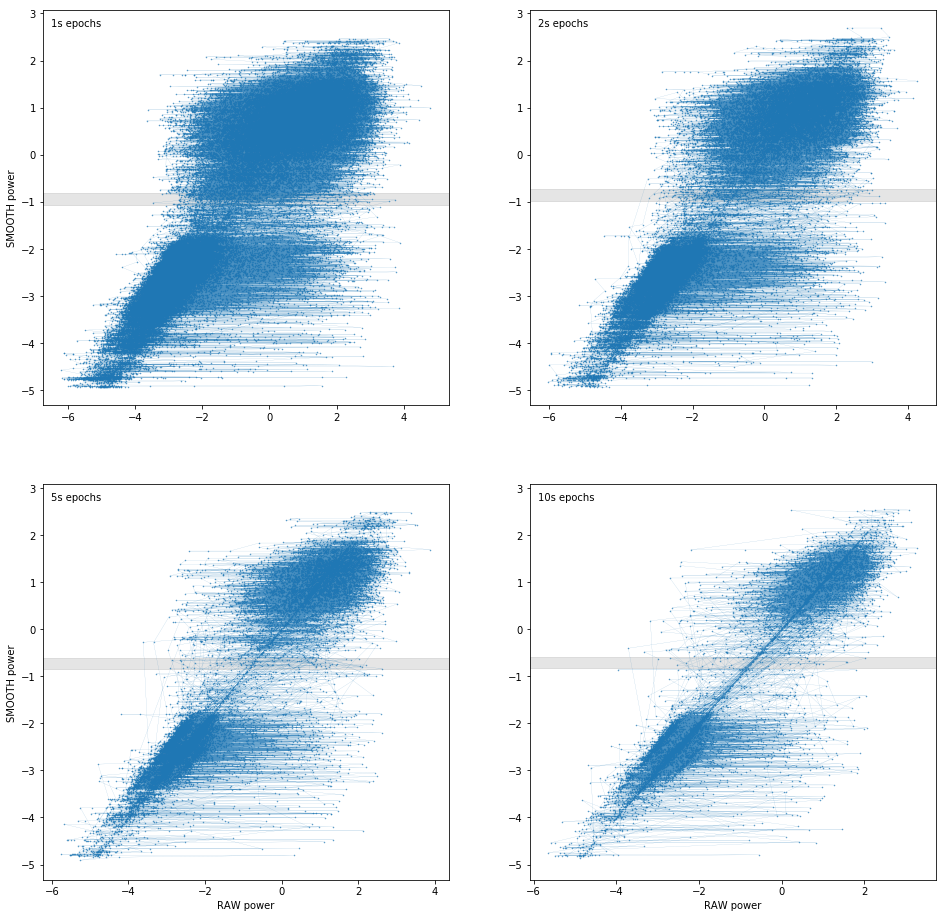

In [36]:
numrow = len(data)

# PLOTTING joint distributions
figxx = plt.figure(figsize=(16, 16))
ax = [plt.subplot(2, 2, 1)]
ax += [plt.subplot(2, 2, 1+i, sharey=ax[0]) for i in range(1,numrow)]


for i, dd in enumerate(data):
    el = dd['epochLength']
    
    raw = dd['tser']['raw']
    pmf90 = dd['tser']['mf90']

    gmm2x_db = raw['gmm2'].xinterval(pdiff=pdiff)
    gmm2y_db = pmf90['gmm2'].xinterval(pdiff=pdiff)
    
    
    ax[i].plot(raw['p'], pmf90['p'], '-o', lw=0.1, ms=0.5, alpha=0.8)
    
    
    #ax[i].axvspan(*gmm2x_db, color='grey', alpha=0.2)
    ax[i].axhspan(*gmm2y_db, color='grey', alpha=0.2)

    ax[i].text(0.02, 0.98, '%is epochs' % el, ha='left', va='top', transform = ax[i].transAxes)

    
    
    
ax[2].set_xlabel('RAW power')
ax[3].set_xlabel('RAW power')


ax[0].set_ylabel('SMOOTH power')
ax[2].set_ylabel('SMOOTH power')

plt.tight_layout